<h1>Модель современного города<h1>
<h3>Работу выполнил студент 3-го курса ЭФ СПбГУ гр. 20.б03-э Шатров Д.И. в 2023 г.<h3>

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import pandas as pd
from math import sqrt
from IPython.display import display, Math
from scipy import linspace
import random
from collections import defaultdict
import statsmodels.tsa.stattools

Переменные управления:
* $Z_t$ -- ввоз в город строительных рабочих за год $t$.
* $K_t$ -- доля нестроительного населения, обучаемая строительной специальности за год $t$.

Параметры:

* $N$ -- максимальное время эксплуатации жилья.
* $M$ -- максимальное время работы в строительстве.

Вектор состояния
* $R_t$ -- население к началу года
* $S_t=\{s_{t,i}\}_{i=1}^N$ -- жилфонд возраста $i$ к началу года $t$.
* $Y_t=\{y_{t,j}\}_{j=1}^M$ -- число рабочих, проработавших $j$ лет к наалу года $t$.

Изменение жилфонда
$$S_t=\begin{pmatrix}s_{t,0}\\s_{t,1}\\\vdots\\s_{t,N}\end{pmatrix}\Rightarrow S_{t+1}=\begin{pmatrix}A\sum_{i=1}^My_{t,i}\\s_{t,0}\\\vdots\\s_{t,N-1}\end{pmatrix}$$

Изменение численности рабочих
$$Y_t=\begin{pmatrix}y_{t,0}\\y_{t,1}\\\vdots\\y_{t,M}\end{pmatrix}\Rightarrow Y_{t+1}=\begin{pmatrix}Z_t+K_t\big(R_t-\sum_{j=1}^My_{t,j}\big)\\y_{t,0}\\\vdots\\y_{t,M-1}\end{pmatrix}$$
Рекуррентное соотношение:
\begin{align*}X_{t+1}=B_tX_T+Z_t
&C_{N\times N}=\begin{pmatrix}0&0&\dots&0&0\\1&0&\dots&0&0\\\dots&\dots&\dots&\dots&\dots&\\0&0&\dots&1&0\end{pmatrix}\\
&D_{N\times M}=\begin{pmatrix}1&\dots&1\\\dots&\dots&\dots\\0&0&0\end{pmatrix}\\
&B_t=\begin{pmatrix}1&0_{1\times N}&0_{1\times M}\\0_{N\times 1}&C_{N\times N}&AD_{N\times M}\\\begin{pmatrix}K_t\\0_{(M-1)\times1}\end{pmatrix}&0_{M\times N}&C_{M\times M}-K_tD_{M\times M}\end{pmatrix}
\end{align*}
Перемножить столбец $B_t X_t+Z_t$
где $$Z_t=\begin{pmatrix}z_t\\0_{N\times 1}\\z_t\\0_{(M-1)\times 1}\end{pmatrix}$$

Конструктор объекта класса city принимает параметры $N,M,R,A$ - наиб. время эксплуатации жилья, наиб. время работы в строительстве, население в начале моделирования, производительность рабочего в кв. км. жилья в год. Будем считать, что естественный прирост населения нулевой.<br><br>
Значение производительности по умолчанию $A=30$ получено на основе данных [Википедии](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D1%80%D0%BE%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D1%81%D1%82%D0%B2%D0%BE_%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8) о вводе в эксплутацию в РФ примерно 100 млн кв. км. жилья при численности работников строительной отрасли ок. 7000000 чел и предположении о том, что примерно половина из этих людей является собственно строителями.<br><br>
На основе полученных параметров случайным образом генерируются начальные значения векторов $S,Y$ состояния жилфонда и распределения строителей по продолжительности работы в отрасли. Предполагается, что начальное общее количество работников находится между 2 и 3% от общей численности населения и распределяется равномерно относительно опыта работы в строительстве.<br><br>
Дополнительно может быть передано значение величины жилищного фонда в начальный момент времени. Введённое значение будет не распределено по годам, а использовано для случайной генерации начального вектора распределения жилья по годам службы.<br><br>
Метод $control$ обновляет векторы $S,Y$ объёма жилищного фонда и количества рабочих на основе введённых значений $Z,K$ количества приехавших строителей и доли остального населения, перешедшей работать в строительную отрасль. Приезжие строители считаются жителями города, то есть увеличивают население.<br><br>
Метод $housing$ вычисляет обеспеченность города жильём в кв. км. на душу населения.

In [81]:
class city:
    def __init__(self,N, M, R_0 = 6000000, A = 30, S_0 = 36000000):
        assert(k > 0 for k in [N,M,R_0,A,S_0]), "Недопустимые значения параметров!"
        self.N = N
        self.M = M
        self.R_0 = R_0
        self.A = A
        self.S_0 = S_0
        self.R = R_0
        self.S = np.random.randint(low = 0, high = 2 * self.S_0 / N,size=(N,1))
        self.Y = np.random.randint(low = self.R_0 * (2)/100, high = self.R_0 * (2 + random.random())/100, size=(M,1)) * (1 / M)
        
    def control(self, Z, K):
        assert(Z >=0 and K >=0 and K <=1), "Недопустимые значения параметров!"
        self.S = np.roll(self.S,1)
        self.Y = np.roll(self.Y,1)
        self.S[0,0] = self.A * np.sum(self.Y)
        self.Y[0,0] = Z + K * (self.R - np.sum(self.Y))
        self.R += Z
        return None
    
    def housing(self):
        return np.sum(self.S)/self.R
        

<h3>Задача №1. Стационарный уровень обеспечения жильём</h3>
Для решения задачи требуется найти $Z_t,K_t:\xi_t=\frac{S_t}{R_t}$ стационарен в широком смысле после  некоторого момента времени $T$.<br><br>
Для поиска управления, обеспечивающего стационарный уровень обеспечения жильём, рассмотрим управление, построим для него прогноз на несколько лет вперёд, а для последних 150-ти лет проверим гипотезу о стационарности обеспечения жильём.<br><br>
Функция $hLT$ принимает на вход экземпляр класса $city$, параметры управления $Z,K$ - количество завезённых строителей и доля нестроителей, перешедших работать в отрасль. Дополнительно может быть передан параметр $h$ - горизонт прогнозирования.

In [98]:
t = city(30,30)
t.housing()

5.967522833333334

In [99]:
def hLT(cite, Z, K, h = 200):
    assert isinstance(cite, city) and (k>=0 for k in [Z,K,h])
    i = 0
    srhist = [cite.housing()]
    while i < h:
        i+=1
        cite.control(Z,K)
        #print(cite.housing())
        srhist.append(cite.housing())
    return srhist
    

In [115]:
ko = t
myarr = hLT(ko, 1000, 0.08, h = 180)

Функция $hda$ позволяет исследовать ряд уровней обеспеченности жильём на стационарность: выводит график ряда, проводит для последних 150-ти наблюдений статистические тесты на единичные корни.

In [116]:
def hda(srhist):
    assert(len(srhist)>=150)
    fig, ax = plt.subplots(figsize=(12, 6))
    xs = [x for x in range(len(srhist))]
    ax.plot(srhist, color='#CC0000', label='Sine wave', linewidth = 2.5)
    plt.ylabel("Обеспеченность жильём, кв.км/чел.")
    plt.xlabel("Годы")
    plt.title("Прогноз обеспеченности жильём")
    plt.xlim([0, len(srhist)])
    plt.show()
    testres = pd.DataFrame(columns = ["Тест","H_0","Статистика","p-value"])
    adfstat, p_adf,_,_,_,_ = statsmodels.tsa.stattools.adfuller(x = srhist[-150:], regression = "ct")
    kpstat, p_kpss,_,_ = statsmodels.tsa.stattools.kpss(x = srhist[-150:], regression = "ct")
    adfres = {"Тест":"ADF", 
                    "H_0":"DS",
                    "Статистика":adfstat,
                    "p-value":p_adf}
    kpssres = {"Тест":"KPSS", 
              "H_0":"TS",
              "Статистика":kpstat,
              "p-value":p_kpss}
    testres = pd.concat([testres, pd.DataFrame([adfres]), pd.DataFrame([kpssres])], ignore_index=True)
    if p_adf < 0.05 and p_kpss >0.05:
        print("Результаты тестов свидетельствуют о том, что стационарный уровень обеспечения жильём достигнут.")
    else:
        print("Результаты тестов не позволяют сказать, что стационарный уровень обеспечения жильём достигнут.")
    return testres
    
    

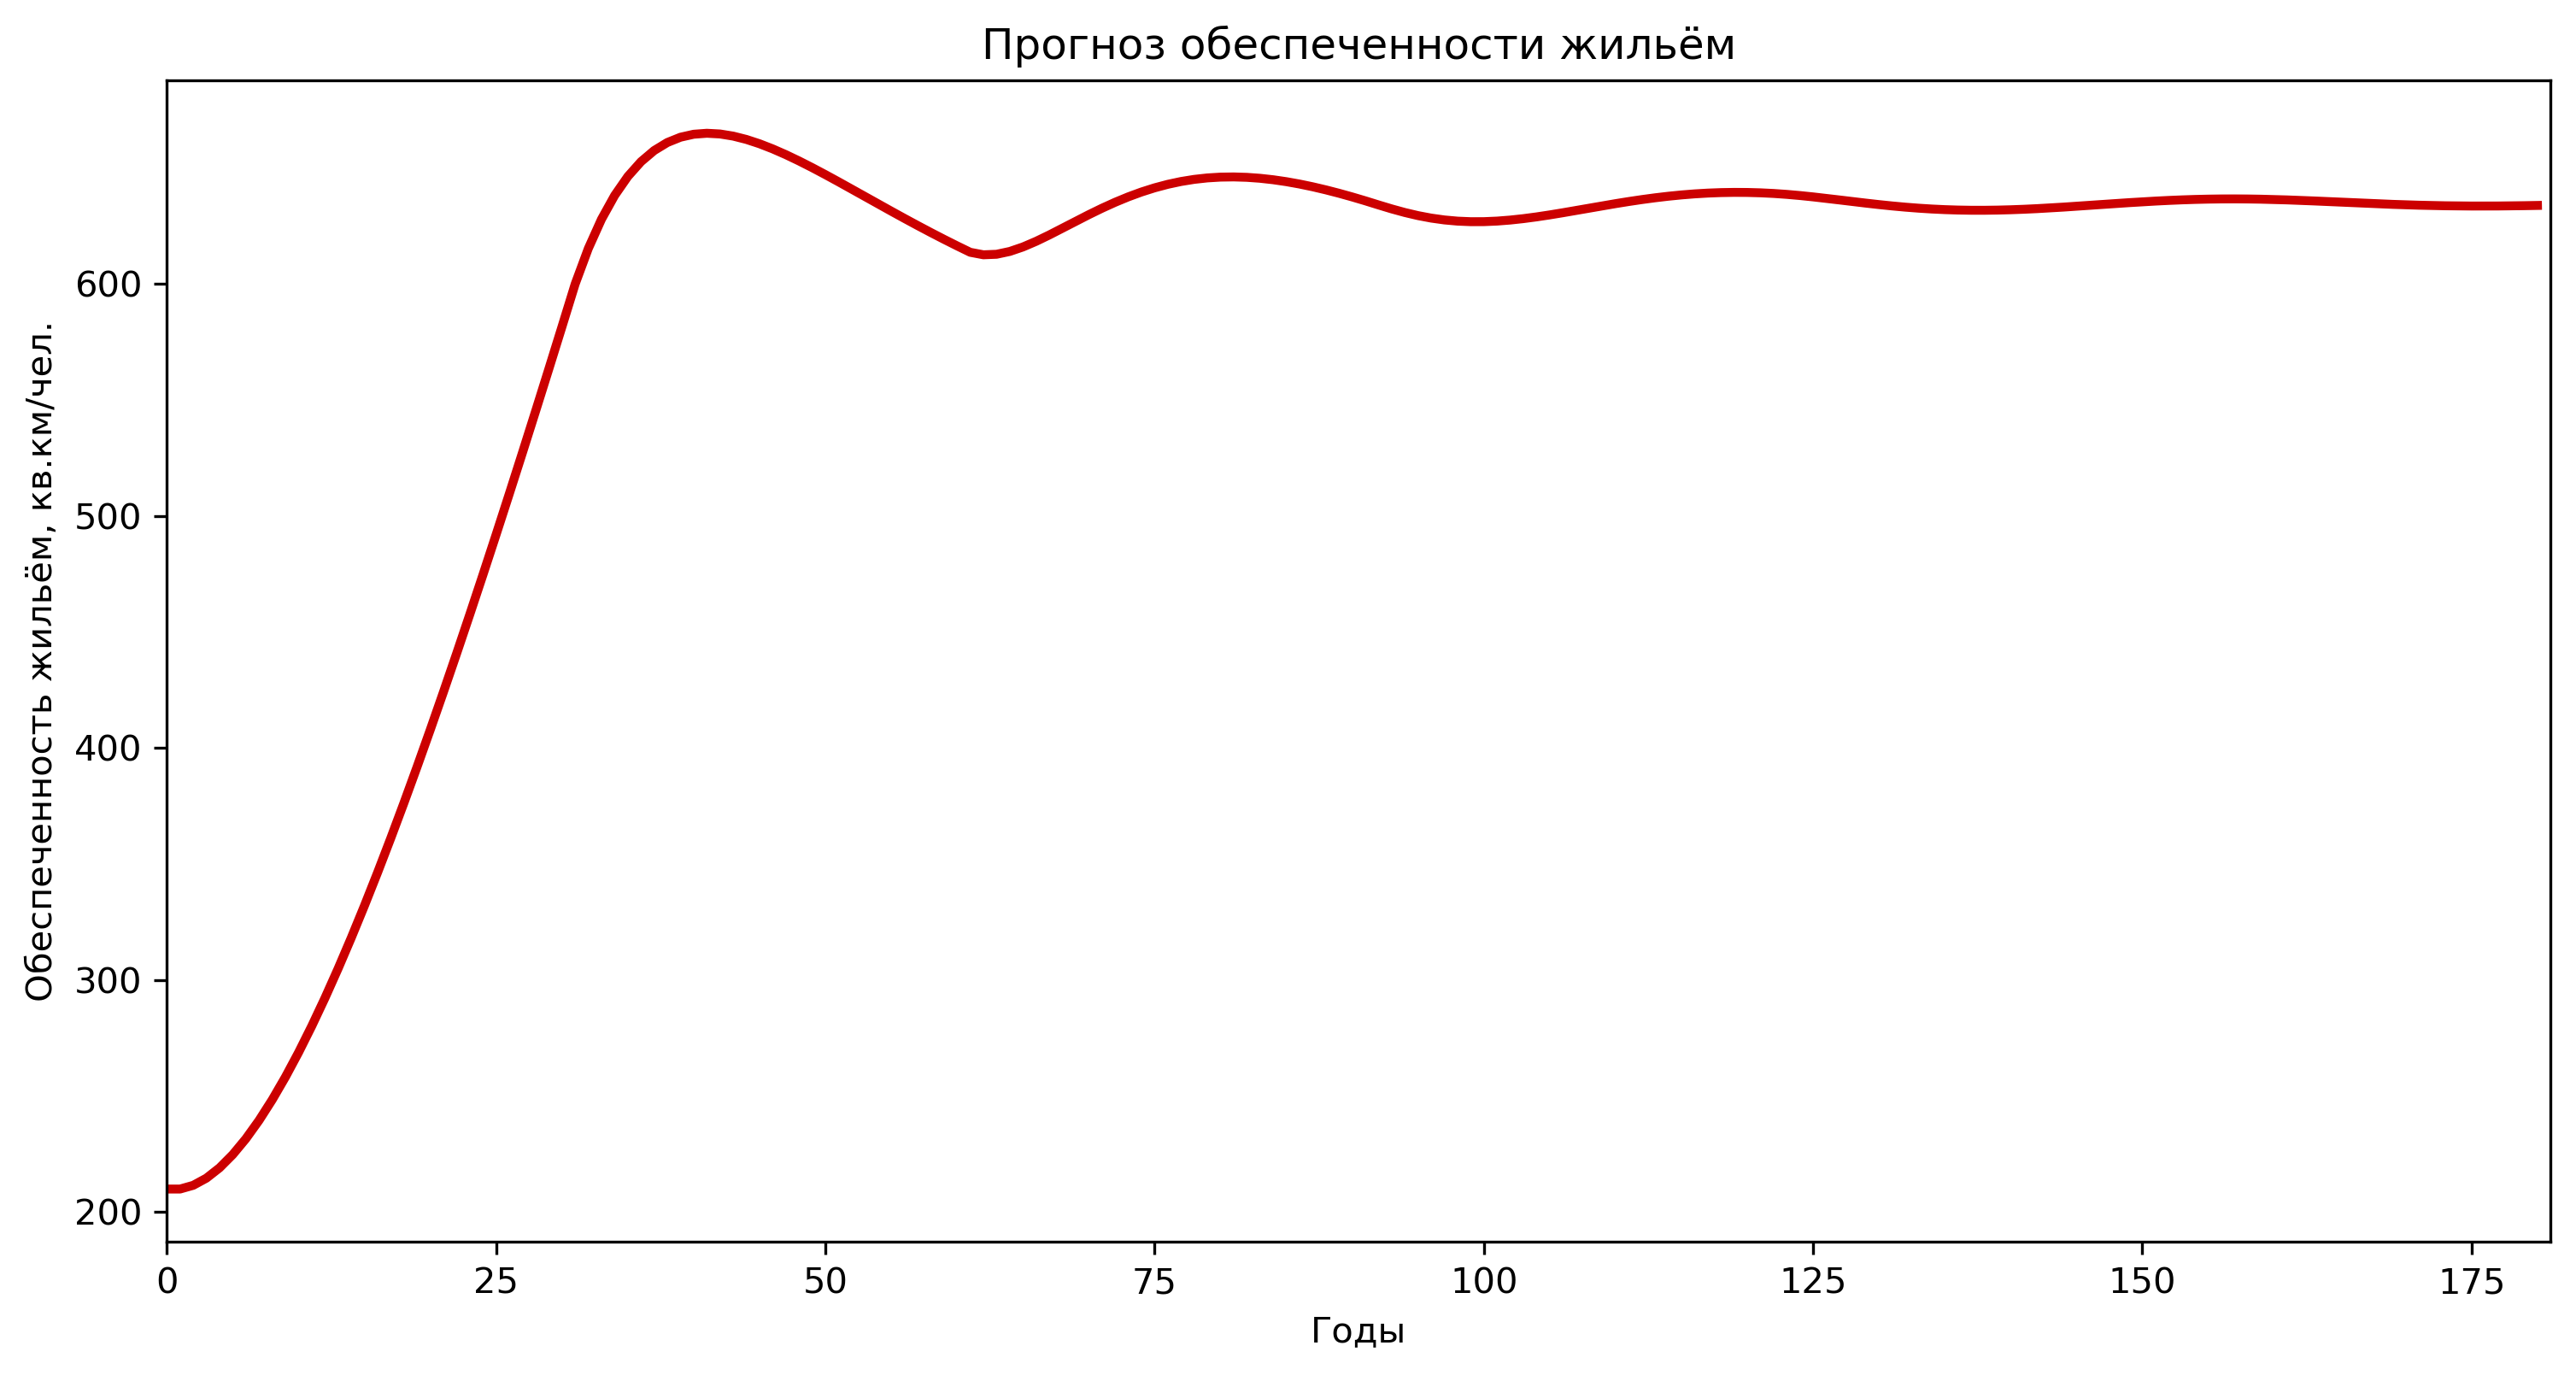

Результаты тестов свидетельствуют о том, что стационарный уровень обеспечения жильём достигнут.


/home/dmitry/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Тест,H_0,Статистика,p-value
0,ADF,DS,-5.954262,0.000003
1,KPSS,TS,0.061491,0.1


In [117]:
hda(myarr)

<h3>Задача №2. Достижение целевого уровня обеспеченности жильём к заданному сроку.</h3>
В этой задаче предполагается, что определены целевое значение обеспечения жильём и срок, к которому это значение должно быть достигнуто.

Функция $housing\_ goal$ принимает на вход город, параметры управления, целевой уровень обеспечения жильём, срок достижения целевого уровня и предельное количество итераций алгоритма.<br><br>
Сначала введённые пользователем параметры управления используются для достижения целевого уровня обеспечения жильём к заданному сроку. Если это сделать не удаётся, то параметры управления изменяются на значение случайной величины, в диапазоне от -10 до +10% от первоначальных. Для новых значений повторяется попытка достичь целевого уровня обеспечения жильём. Если через $maxiter$ попыток это сделать не удаётся, выполнение алгоритма завершается неудачей.

In [118]:
def housing_goal(cite, Z = 1000, K = 0.001, goal = 20, T = 100, maxiter = 1000):
    assert isinstance(cite, city) and (k>=0 for k in [Z,K,goal,T,maxiter]), "Неприемлемые входные параметры!"
    iters = 0
    housing_res =  hLT(cite, Z, K, T)[-1]
    while iters < maxiter:
        iters+=1
        if housing_res >= goal:
            print("Целевой уровень достигнут на %d-м шаге с параметрами Z=%0.2f, K=%0.2f."%(iters,Z,K))
            break 
        else:
            Z = Z + random.uniform(-Z/10,Z/10)
            K = K + random.uniform(-K/10, K/10)
            for par in [Z,K]:
                if par < 0:
                    par = abs(par)
        housing_res =  hLT(cite, Z, K, T)[-1]
    if(housing_res < goal):
        print("Целевого уровня в заданный срок достичь не удалось.")
    return housing_res,Z,K,iters
        
    
    
    
    

In [119]:
clone = t
housing_goal(clone, Z = 500, K = 0.001, goal = 45, T = 1000, maxiter = 500)

Целевой уровень достигнут на 397-м шаге с параметрами Z=195.06, K=0.00.


(46.93479910122828, 195.05658461130784, 0.0018328362096079057, 397)